### Example 1 - Map of chlorophyll content in the North West Atlantic (Amazon S3 version)

This example will show you how to read and manipulate Argo profiles data stored in parquet format in WHOI's AWS S3 data lake. 

The data are stored across multiple files: we will load into memory only what we need by applying some filters, and we will create a map showing the chlorophyll content in the North West Atlantic.

##### Note on AWS S3

In this example we will access data stored in WHOI's **AWS S3** data lake. Reading data from WHOI's Poseidon cluster is slightly different and we refer you to dedicated examples (manipulating the data once loaded into the memory does not change).

NB: Access to the data lake should be public at this time. If you get some permission error, [reach out](enrico.milanese@whoi.edu).

##### Note on parquet files

The original netCDF Argo files have been converted to parquet format, which provides faster read operations.

There are a couple of way to read parquet files in Python. One is by directly using pandas (make sure you have pyarrow, fastparquet or some other suitable engine installed), the other is with Dask. Generally speaking, you'll want to use Dask if you need a large amount of data at the same time so that you can benefit from its parallelization. You should avoid Dask and just go for pandas whenever the data fits in your RAM.

When reading parquet files with pandas, you can either specificy the file name (if you know which file you want), or the directory containing all the parquet files. In latter case if you apply any filter, pandas and pyarrow will sort through all the files in the folder, reading into memory only the subsets that satisfy your filter.

#### Getting started

We start by importing the necessary modules and setting the path and filenames of the parquet files. For a list of modules that you need to install, you can look at the [README.md file in the repository](https://github.com/boom-lab/nc2parquet).

In [1]:
from datetime import datetime
import numpy as np
import pandas as pd
import xarray as xr
import pyarrow.parquet as pq
import glob
from pprint import pprint

# Importing AWS S3 modules, setting AWS S3 paths and file system
from pyarrow import fs
import boto3
from botocore import UNSIGNED
from botocore.client import Config
client = boto3.client('s3', config=Config(signature_version=UNSIGNED), region_name='us-east-1')

response = client.list_objects_v2(
    Bucket='argo-experimental',
    Prefix='pqt/')

aws_path ='s3://argo-experimental/'
pqt_files_aws = []
for content in response.get('Contents', []):
    if content['Key'].endswith('.parquet') and not 'metadata' in content['Key']:  # Check if it ends with .parquet and is not in a subfolder
        pqt_files_aws.append(aws_path + content['Key'])

fs, _ = fs.FileSystem.from_uri(pqt_files_aws[0])

# We import argopy only for speed comparisons
import argopy
argopy.reset_options()

We now want to set up our filter to read only the data from the NWA (i.e. latitude between 34$^\circ$ and 60$^\circ$, longitude between -45$^\circ$ and -78$^\circ$).

We first query the parquet files for the variable names, as we might not be familiar with them, or we might want to make sure that indeed the names have not been changed from the Argo convention.

In [2]:
dataset = pq.ParquetDataset([pqt_file.strip("s3://") for pqt_file in pqt_files_aws], filesystem=fs)
schema = dataset.schema
pprint(sorted(schema.names))

['BBP700',
 'BBP700_ADJUSTED',
 'BBP700_ADJUSTED_ERROR',
 'BBP700_ADJUSTED_QC',
 'BBP700_QC',
 'BBP700_dPRES',
 'CDOM',
 'CDOM_ADJUSTED',
 'CDOM_ADJUSTED_ERROR',
 'CDOM_ADJUSTED_QC',
 'CDOM_QC',
 'CDOM_dPRES',
 'CHLA',
 'CHLA_ADJUSTED',
 'CHLA_ADJUSTED_ERROR',
 'CHLA_ADJUSTED_QC',
 'CHLA_QC',
 'CHLA_dPRES',
 'CYCLE_NUMBER',
 'DOXY',
 'DOXY_ADJUSTED',
 'DOXY_ADJUSTED_ERROR',
 'DOXY_ADJUSTED_QC',
 'DOXY_QC',
 'DOXY_dPRES',
 'JULD',
 'LATITUDE',
 'LONGITUDE',
 'NITRATE',
 'NITRATE_ADJUSTED',
 'NITRATE_ADJUSTED_ERROR',
 'NITRATE_ADJUSTED_QC',
 'NITRATE_QC',
 'NITRATE_dPRES',
 'N_LEVELS',
 'N_PROF',
 'PH_IN_SITU_TOTAL',
 'PH_IN_SITU_TOTAL_ADJUSTED',
 'PH_IN_SITU_TOTAL_ADJUSTED_ERROR',
 'PH_IN_SITU_TOTAL_ADJUSTED_QC',
 'PH_IN_SITU_TOTAL_QC',
 'PH_IN_SITU_TOTAL_dPRES',
 'PLATFORM_NUMBER',
 'PRES',
 'PRES_ADJUSTED',
 'PRES_ADJUSTED_ERROR',
 'PRES_ADJUSTED_QC',
 'PRES_QC',
 'PSAL',
 'PSAL_ADJUSTED',
 'PSAL_ADJUSTED_ERROR',
 'PSAL_ADJUSTED_QC',
 'PSAL_QC',
 'PSAL_dPRES',
 'TEMP',
 'TEMP_ADJUSTED

The geographical coordinates are stored in the variables 'LATITUDE'and 'LONGITUDE'. We then generate the filter, with its syntax being: `[[(column, op, val), …],…]` where `column` is the variable name, and `val` is the value to for the operator `op`, which accepts `[==, =, >, >=, <, <=, !=, in, not in]`,

In [3]:
filter_coords = [("LATITUDE",">",34), ("LATITUDE","<",80),
                 ("LONGITUDE",">",-78), ("LONGITUDE","<",-50)]

To get a pandas dataframe, we need first to create a parquet dataset that pyarrow can read with `ParquetDataset()`, then we read it into a pandas dataframe with `pead().to_pandas()` methods of the dataset. The filters are applied when `ParquetDataset()` is called.

**NB:** The following operation still fetches a large amount of data (~4.8 GB), so you can skip executing it if your machine does not have enough memory and/or your internet connection isn't great.

In [4]:
ds = pq.ParquetDataset([pqt_file.strip("s3://") for pqt_file in pqt_files_aws], filesystem=fs, filters=filter_coords)

In [5]:
%%time
df = ds.read().to_pandas()
df

CPU times: user 1min 23s, sys: 2min 11s, total: 3min 35s
Wall time: 1min 14s


PLATFORM_NUMBER  PRES   LATITUDE  DOXY_ADJUSTED_QC  TEMP_QC  \
N_PROF N_LEVELS                                                                
0      0                 4903798   0.0  56.123187               3.0        8   
       1                 4903798   0.1  56.123187               3.0        8   
       2                 4903798   0.2  56.123187               3.0        8   
       3                 4903798   0.3  56.123187               3.0        8   
       4                 4903798   0.4  56.123187               3.0        8   
...                          ...   ...        ...               ...      ...   
29     1332              4902600   NaN  37.155403               0.0        0   
       1333              4902600   NaN  37.155403               0.0        0   
       1334              4902600   NaN  37.155403               0.0        0   
       1335              4902600   NaN  37.155403               0.0        0   
       1336              4902600   NaN  37.155403               0.0        0   

                 DOXY_ADJUSTED  PSAL_QC        DOXY  TEMP_ADJUSTED_QC  \
N_PROF N_LEVELS                                                         
0      0            327.642975        4  286.802307                 0   
       1            329.894165        4  288.772888                 0   
       2            335.020416        4  293.260162                 0   
       3            349.127930        4  305.609161                 0   
       4            361.651794        4  316.571930                 0   
...                        ...      ...         ...               ...   
29     1332                NaN        0         NaN                 0   
       1333                NaN        0         NaN                 0   
       1334                NaN        0         NaN                 0   
       1335                NaN        0         NaN                 0   
       1336                NaN        0         NaN                 0   

                 TEMP_ADJUSTED  ...  PH_IN_SITU_TOTAL_dPRES  \
N_PROF N_LEVELS                 ...                           
0      0                   NaN  ...                     0.0   
       1                   NaN  ...                     0.0   
       2                   NaN  ...                     0.0   
       3                   NaN  ...                     0.0   
       4                   NaN  ...                     0.0   
...                        ...  ...                     ...   
29     1332                NaN  ...                     NaN   
       1333                NaN  ...                     NaN   
       1334                NaN  ...                     NaN   
       1335                NaN  ...                     NaN   
       1336                NaN  ...                     NaN   

                 PH_IN_SITU_TOTAL_ADJUSTED  PH_IN_SITU_TOTAL_ADJUSTED_QC  \
N_PROF N_LEVELS                                                            
0      0                               NaN                           0.0   
       1                               NaN                           0.0   
       2                               NaN                           0.0   
       3                               NaN                           0.0   
       4                               NaN                           0.0   
...                                    ...                           ...   
29     1332                            NaN                           NaN   
       1333                            NaN                           NaN   
       1334                            NaN                           NaN   
       1335                            NaN                           NaN   
       1336                            NaN                           NaN   

                 PH_IN_SITU_TOTAL_ADJUSTED_ERROR NITRATE  NITRATE_QC  \
N_PROF N_LEVELS                                                        
0      0                                     NaN     NaN         NaN   
 

You can explore the dataframe just by calling it (`df`) as we did above. If you want a list of the variables that are stored, you can use `sorted(df.columns.to_list())`.

#### Timing test

The time taken by the call above depends on your internet connection. These are some times I experienced:

* Eduroam @ WHOI, notebook executed on Poseidon (avg ping = 10ms): 1min 27s
* Eduroam @ WHOI, notebook executed on my machine (avg ping = 70ms): 10min 19s
* Home connection, notebook executed on Poseidon (avg ping = 10ms): 1min 11s
* Home connection, notebook executed on my machine (avg ping = 26ms): 2min 4s
  
(Note that the ping measured for Poseidon executions is the time that Poseidon takes to ping the server, so when fetching the data there's always some more overhead to then move them from Poseidon to your machine, which depends on your own internet connection.)

Now that we are aware of how relevant our own internet connection is, I will report only results measured in the first setting (Eduroam @ WHOI, notebook executed on Poseidon).

We now want to compare our approach with Argopy's functionalities. Its data fetcher requires to specificy the depth range, which we then set to between 0 and 10000, i.e. all depths present in the dataset.

NB: the execution should throw an exception (if it doesn't, let me know!). This is likely due to ERDDAP's servers timing out after 1 min (as the wall time consistently measures).

In [6]:
%%time
f = argopy.DataFetcher()
f = f.region([-78, -50, 34, 80, 0, 10000])
try:
    f.load()
except Exception as e:
    print(f"Exception: {e}")

Exception: 
CPU times: user 10.8 ms, sys: 8.6 ms, total: 19.4 ms
Wall time: 1min


We just saw that if we need a large amount of data, our parquet-based mirror of Argo's data can bypass that 1 min ERDDAP time out.

Now let's narrow the filters in the time and depth -- let's say we we want to select the data for the past three months and measured between 0 and 50 db. Note that the pyarrow's syntax cannot explicitly remove non-valid numbers, so to retrieve valid entries for our the chlorophyl, we filter by allowing its value to be inside a very large range.

In [7]:
from datetime import datetime, timedelta
reference_time = datetime.utcnow() - timedelta(days=90)
filter_coords_time_pres = [("LATITUDE",">",34), ("LATITUDE","<",80),
                           ("LONGITUDE",">",-78), ("LONGITUDE","<",-50),
                           ("JULD",">",reference_time),
                           ("PRES_ADJUSTED",">=",0),("PRES_ADJUSTED","<=",50),
                           ("CHLA_ADJUSTED",">=",-1e30),("CHLA_ADJUSTED","<=",+1e30)]

f = argopy.DataFetcher()
today_date = datetime.today()
old_date = today_date - timedelta(days=90)
today_date = today_date.strftime('%Y-%m')
old_date = old_date.strftime('%Y-%m')
f = f.region([-78, -50, 34, 80, 0, 50, old_date, today_date])

In [8]:
%%time
ds = pq.ParquetDataset([pqt_file.strip("s3://") for pqt_file in pqt_files_aws], filesystem=fs, filters=filter_coords_time_pres)
df = ds.read().to_pandas()

CPU times: user 1min 2s, sys: 1min 24s, total: 2min 26s
Wall time: 1min


In [9]:
%%time
f.load()

/vortexfs1/home/enrico.milanese/projects/ARGO/nc2parquet/venv/venv3.9/lib/python3.9/site-packages/argopy/xarray.py:70: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  self._dims = list(xarray_obj.dims.keys())
/vortexfs1/home/enrico.milanese/projects/ARGO/nc2parquet/venv/venv3.9/lib/python3.9/site-packages/argopy/xarray.py:70: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  self._dims = list(xarray_obj.dims.keys())
/vortexfs1/home/enrico.milanese/projects/ARGO/nc2parquet/venv/venv3.9/lib/python3.9/site-packages/argopy/xarray.py:70: FutureWarning: The return type of `Dataset.dims` will be change

CPU times: user 1.87 s, sys: 407 ms, total: 2.28 s
Wall time: 32.7 s


<datafetcher.erddap>
Name: Ifremer erddap Argo data fetcher for a space/time region
API: https://erddap.ifremer.fr/erddap
Domain: [x=-78.00/-50.00; y=34.00/80.0 ... 50.0; t=2024-04-01/2024-07-01]
Performances: cache=False, parallel=False
User mode: standard
Dataset: phy

It took around a minute for our Argo mirror, and 36 seconds using Argo ERDDAP's servers. These can be faster when we need to access a contained amount of data.

#### Map

As in this example we are only interested in the chlorophyll, we can specify it as the only column to import (together with the geographical and temporal coordinates). We do this through the variable `columns` of `read_parquet()`. We also adjust the filter to consider only data labeled with QC=1.

In [10]:
%%time
ref_var = 'CHLA_ADJUSTED'
cols = [ref_var,ref_var+"_QC","LATITUDE","LONGITUDE","PRES_ADJUSTED","JULD"]
filter_coords_time_pres = [("LATITUDE",">",34), ("LATITUDE","<",80),
                           ("LONGITUDE",">",-78), ("LONGITUDE","<",-50),
                           ("JULD",">",reference_time),
                           ("PRES_ADJUSTED",">=",0),("PRES_ADJUSTED","<=",50),
                           (ref_var,">=",-1e30),(ref_var,"<=",+1e30),(ref_var+"_QC","==",1.0)]
ds = pq.ParquetDataset([pqt_file.strip("s3://") for pqt_file in pqt_files_aws], filesystem=fs, filters=filter_coords_time_pres)
df = ds.read(columns=cols).to_pandas()

CPU times: user 8.4 s, sys: 6.46 s, total: 14.9 s
Wall time: 20.5 s


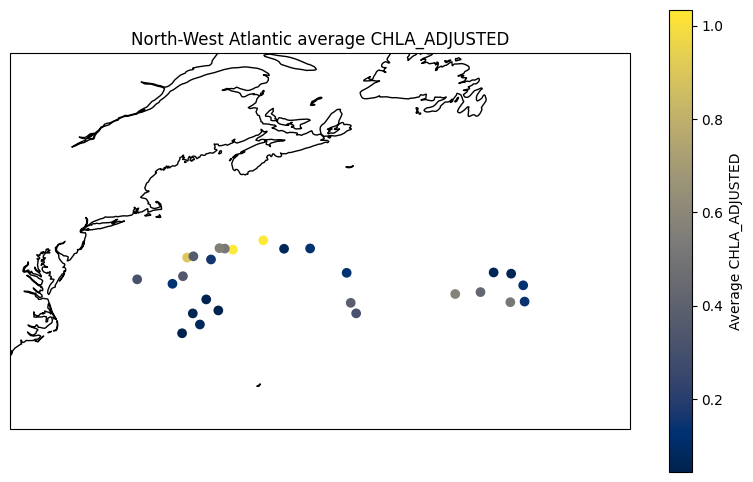

In [11]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from matplotlib import colormaps

# Convert 'JULD' column to datetime type
df['JULD'] = pd.to_datetime(df['JULD'])

# Group by 'LATITUDE' and 'LONGITUDE', and aggregate by averaging over 'PRES_ADJUSTED', 'JULD', and 'CHLA_ADJUSTED'
grouped = df.groupby(['LATITUDE', 'LONGITUDE']).agg({
    'PRES_ADJUSTED': 'mean',  # Take the mean depth
    'JULD': lambda x: x.tolist(),  # Collect all time values into a list
    ref_var: 'mean'  # Take the mean intensity
}).reset_index()

# Plotting using Cartopy
plt.figure(figsize=(10, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()

# Scatter plot
cbar_min = df[ref_var].quantile(q=0.1)
cbar_max = df[ref_var].quantile(q=0.9)
plt.scatter(grouped['LONGITUDE'], grouped['LATITUDE'], c=grouped[ref_var], vmin=cbar_min, vmax=cbar_max, cmap='cividis', transform=ccrs.PlateCarree())
plt.colorbar(label='Average ' + ref_var)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('North-West Atlantic average ' + ref_var)
plt.grid(True)
plt.xlim([-78, -45])
plt.ylim([30, 50])
plt.show()

#### Exercise

Try and access some other metadata, for example:
* filtering by different time periods;
* mapping a different parameter;
* restraining the quality of the data further by imposing PRES_ADJUSTED_ERROR smaller than 20db;
* performing reads/manipulations that you would need to perform your tasks.

If you encounter any issues, please [reach out](enrico.milanese@whoi.edu)!